# **2.0 - Data Visualization**: Mildew Detection Project

---

## Objectives

* To Answer Business Requirement 01:
    * **The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.**
    * Create visualizations to help understand and compare the appearance of healthy versus mildew-infected cherry leaves.

## Inputs

* `inputs/cherry_leaves_dataset/cherry-leaves/train`
* `inputs/cherry_leaves_dataset/cherry-leaves/test`
* `inputs/cherry_leaves_dataset/cherry-leaves/validation`

## Outputs

* Visualizations showing the mean and variability of images per label.
* Plots that contrast images of mildew-infected cherry leaves with healthy cherry leaves.
* Code and data visualizations that address **Business Requirement 01** and support the development of an image montage for the Streamlit dashboard.

## Additional Comments

* No Comments.



---

## 2.1 - Set Up

---

### 2.1.1 - Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### 2.1.2 - Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/Mildew-Detection-CL')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Mildew-Detection-CL'

### 2.1.3 - Set Input Directories

Set the paths for **Train**, **Validation**, and **Test**

In [5]:
data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'

train_path = data_dir + '/train'

valid_path = data_dir + '/validation'

test_path = data_dir + '/test'

### 2.1.4 - Set Output Directory

In [6]:
version = 'v1'

file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### 2.1.5 - Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## 2.2 - Data Visualization of Image Data

---

### 2.2.1 - Label Distribution Across the Subsets of Train, Validation and Test

---

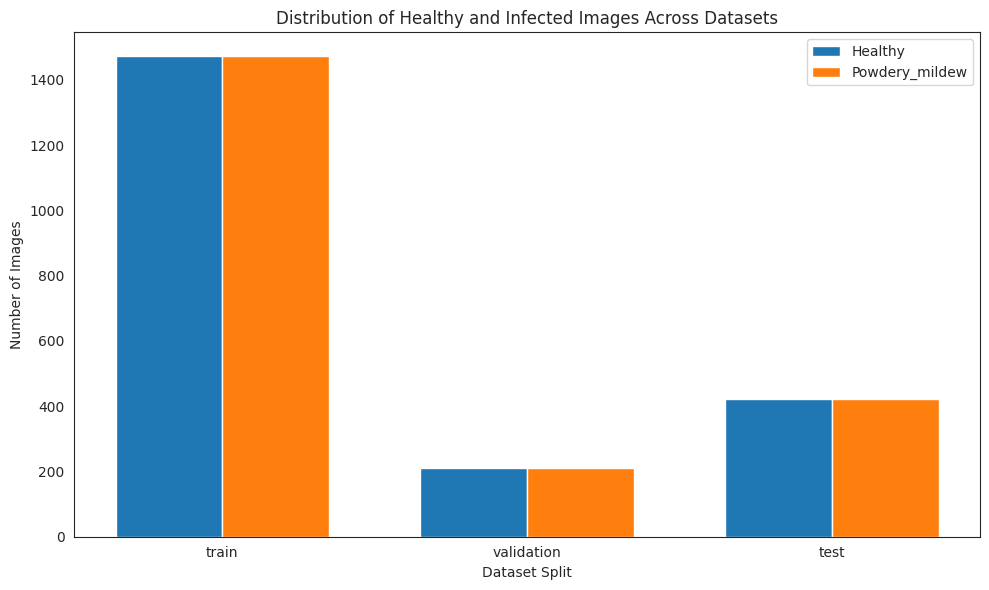

In [8]:
output_dir = "/workspace/Mildew-Detection-CL/outputs"

splits = ['train', 'validation', 'test']
categories = ['healthy', 'powdery_mildew']

split_counts = {split: [] for split in splits}

for split in splits:
    for category in categories:
        category_dir = os.path.join(data_dir, split, category)
        count = len(os.listdir(category_dir))
        split_counts[split].append(count)

bar_width = 0.35
x = np.arange(len(splits))

fig, axis = plt.subplots(figsize=(10, 6))

for i, category in enumerate(categories):
    axis.bar(x + i * bar_width, [split_counts[split][i] for split in splits], 
             width=bar_width, label=category.capitalize())

axis.set_xlabel('Dataset Split')
axis.set_ylabel('Number of Images')
axis.set_title('Distribution of Healthy and Infected Images Across Datasets')
axis.set_xticks(x + bar_width / 2)
axis.set_xticklabels(splits)
axis.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'label_distribution_splits.png'))
plt.show()


### 2.2.2 - Average and Variability of Images Per Label

---

#### 2.2.2.1 - Function to load images in an array (tensor)

In [9]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(data_dir, new_size=(100, 100), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

#### 2.2.2.2 - Load image shapes and labels in an array

In [10]:
X, y = load_image_as_array(data_dir=train_path,
                           new_size=(100, 100),
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


#### 2.2.2.3 - Plot and Save Mean and Variability of Images Per Label

In [11]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        boolean_mask = (y == label_to_display)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


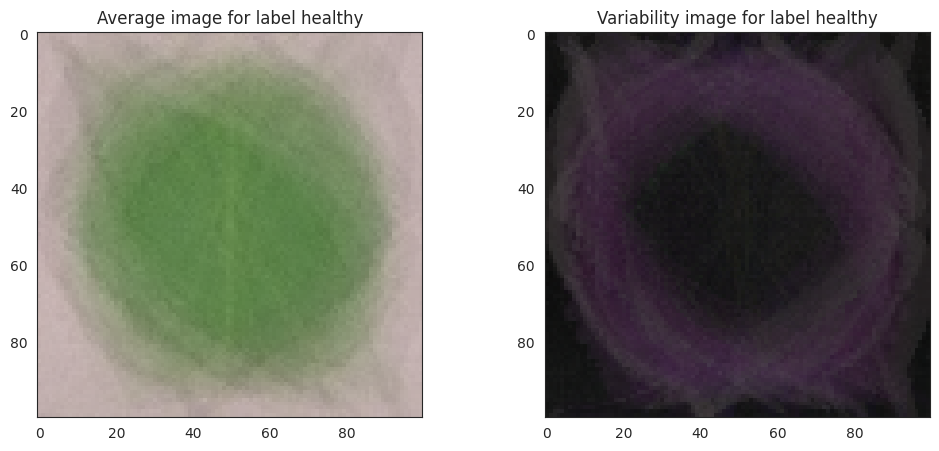

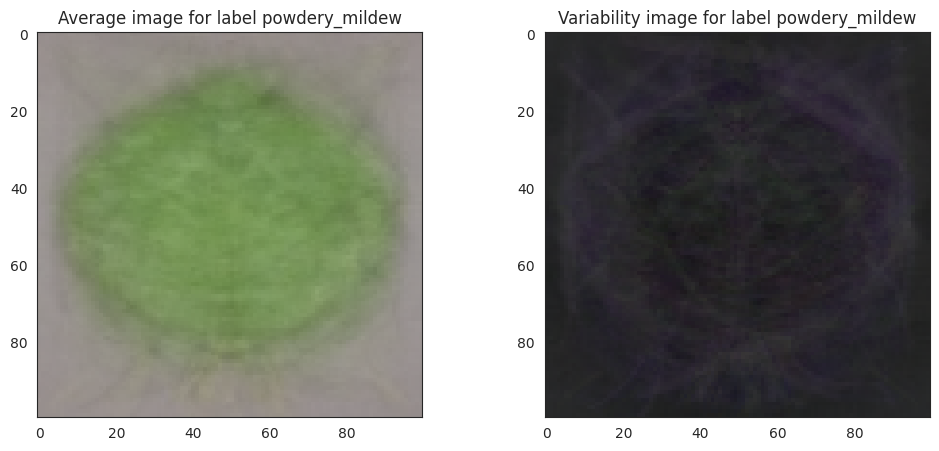

In [12]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

### 2.2.3 - Difference between Average **Mildew-Infected** Images and Average **Healthy** Images

---

In [13]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label_1} or label {label_2}, are not in {np.unique(y)} ")
        return

    images_label1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label1, axis=0)

    images_label2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label2, axis=0)

    difference_mean = label1_avg - label2_avg

    difference_mean_normal = (difference_mean - np.min(difference_mean)) / (np.max(difference_mean) - np.min(difference_mean))

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean_normal, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

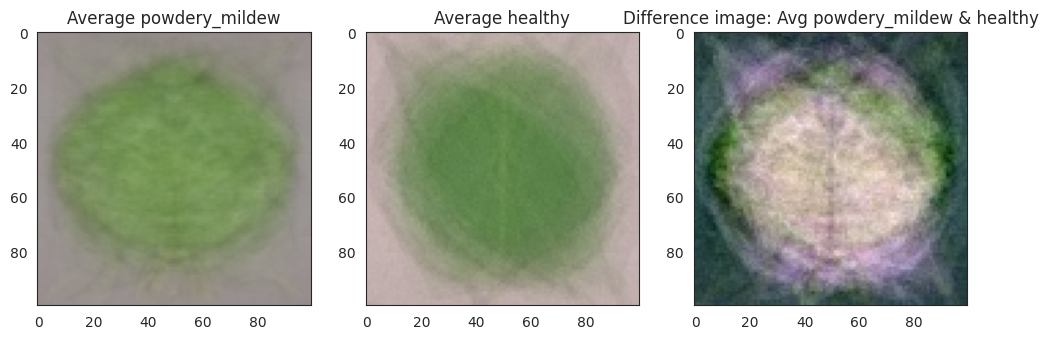

In [14]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

### 2.2.4 - Image Montage

---

In [15]:
import itertools
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    
    labels = os.listdir(dir_path)

    if label_to_display in labels:

        images_list = os.listdir(os.path.join(dir_path, label_to_display))
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} images in your subset. "
                f"You requested a montage with {nrows * ncols} spaces.")
            return

        plot_idx = list(itertools.product(range(nrows), range(ncols)))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(nrows * ncols):
            img = imread(os.path.join(dir_path, label_to_display, img_idx[x]))
            axes[plot_idx[x]].imshow(img)
            axes[plot_idx[x]].set_title(f"{label_to_display.replace('_', ' ').upper()}")
            axes[plot_idx[x]].set_xticks([])
            axes[plot_idx[x]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


Run Montage in all labels

Generating montage for label: HEALTHY


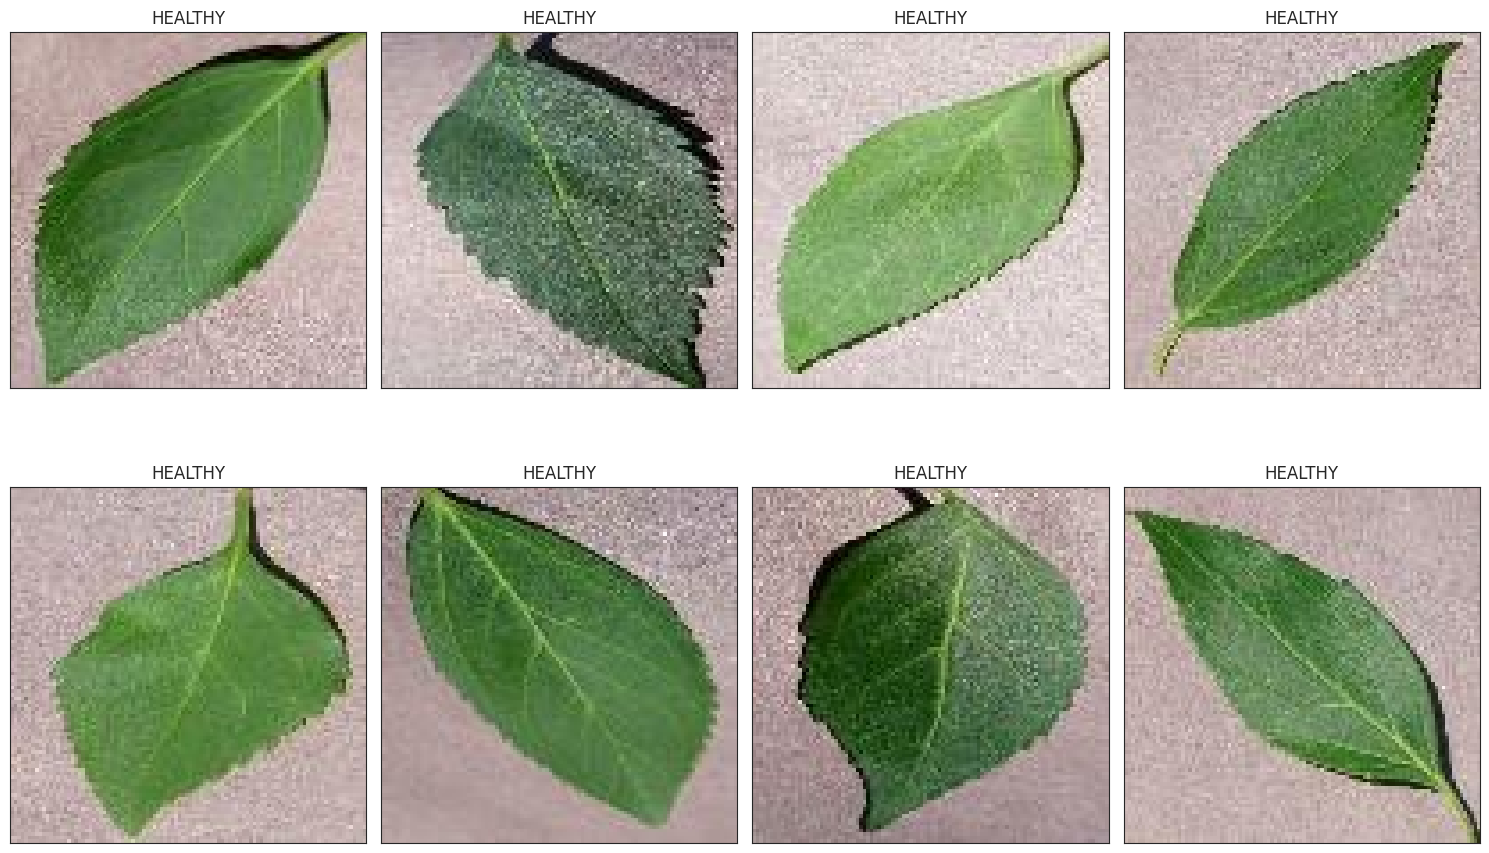



Generating montage for label: POWDERY_MILDEW


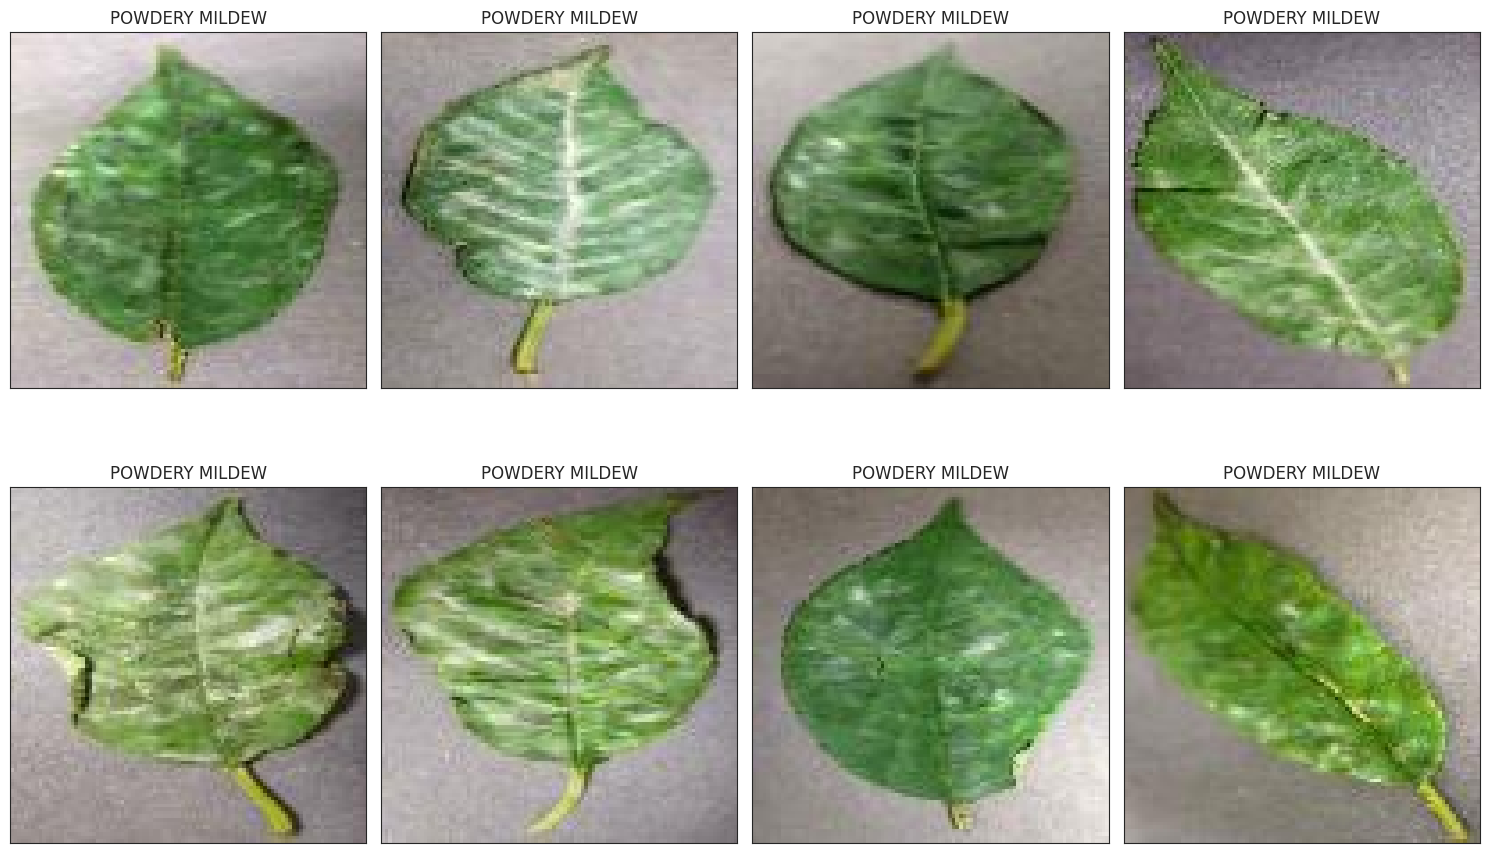

In [16]:
train_dir = train_path

for label in labels:
    print(f"Generating montage for label: {label.upper()}")
    image_montage(dir_path=train_dir,
                  label_to_display=label,
                  nrows=2, ncols=4,
                  figsize=(15, 10)
                  )
    print("\n")

## 2.3 - Conclusion

---

This notebook has achieved the following:

* **Dataset Preparation**: Set up paths for training, validation, and test datasets, and ensured directory structures were correct.

* **Data Visualization**:
  - Created plots to show label distribution across datasets.
  - Generated visualizations of average and variability images per label.
  - Analyzed and compared average images of healthy and mildew-infected leaves.

* **Image Montage**:
  - Produced montages for each label, providing a visual overview of image samples for both healthy and infected cherry leaves.

These steps support the objective of differentiating between healthy and powdery mildew-infected cherry leaves and will aid in further analysis and interactive dashboard development.